In [8]:
import numpy as np
import pandas as pd
import h5py as hf
import torch
import pickle
import pytorch_lightning as pl
from pathlib import Path
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import RMSE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [22]:
# Presets for the notebook
SAMPLE_DATA_FILE = "../bes_data/sample_data/sample_elm_events.hdf5"
RUN_DIR = Path("../../bes-edgeml-work/test_tft") # directory for storing logs and checkpoints
TARGET = 'mean' # use 'mean' for predicting 't_to_elm' for predicting time to ELM or 'log_t_to_elm' for predicting log(time to ELM)
SWS = 512
LOOKAHEAD = 256
BATCH_SIZE = 128
N_EPOCHS = 2
N_WORKERS = 24
N_GPUS = 0
LEARNING_RATE = 0.03
HIDDEN_SIZE = 16 # size of hidden layers in network
N_HEADS = 4 # number of attention heads.

# Optuna hyperparameter tuning
OPTUNA_STUDY_NAME = "tft_study"
OPTUNA_N_TRIALS = 1 # set to 0 to disable
OPTUNA_TIMEOUT = 60 * 60 * 24 # 24 hours
OPTUNA_MAX_EPOCHS = 2
OPTUNA_HIDDEN_SIZE_RANGE = (16, 128)
OPTUNA_N_HEADS_RANGE = (1, 32)

BEST_MODEL_PATH = RUN_DIR / "best_model.ckpt" # THIS MUST BE SPECIFIED IF trainer.checkpoint_callback.best_model_path IS NOT SET

In [10]:
# load data
with hf.File(SAMPLE_DATA_FILE) as ds:
    ds_list = []
    for key in ds.keys():
        ds_df = pd.DataFrame(np.array(ds[key]['signals']).T).add_prefix('channel_')
        if TARGET == 'mean':
            ds_df['target'] = ds_df.mean(axis=1)
        elif TARGET == 't_to_elm':
            ds_df['target'] = ds_df.index.array - ds_df.index.array[ds_df['label'] == 1][0]
        elif TARGET == 'log_t_to_elm':
            ds_df['target'] = np.log(ds_df.index.array - ds_df.index.array[ds_df['label'] == 1][0])
        else:
            raise ValueError("Invalid target")
        ds_df['shot_id'] = key
        ds_df['label'] = np.array(ds[key]['labels'])
        ds_df = ds_df.reset_index().rename(columns={'index': 'time_idx'})
        ds_df = ds_df.iloc[: ds_df.loc[ds_df['label'].diff() == -1].index[0]] # remove everything after the ELM
        ds_list.append(ds_df)

data = pd.concat(ds_list, ignore_index=True)

In [11]:
# create dataset
max_prediction_length = LOOKAHEAD
max_encoder_length = SWS

training_cutoff = data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='target',
    group_ids=['shot_id'],
    min_encoder_length=max_encoder_length // 2,  # allow model to see half of the data
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[col for col in data.columns if col.startswith('channel_')] + ['target'],
    target_normalizer=None,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    predict_mode=True,
)

In [12]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
train_dataloader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
val_dataloader = validation.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

In [13]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


2.2842040061950684

In [14]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=False, mode='min')
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(RUN_DIR / "lightning_logs")  # logging results to a tensorboard
# This is the checkpoint callback that will save the best model so far.
ckpt = ModelCheckpoint(
    dirpath=RUN_DIR / "checkpoints",
    filename="tft-epoch={epoch:02d}-val_loss={val_loss:.2f}",
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',)

# The trainer handles the training loop, evaluation loop, and logging.
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=[N_GPUS],
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, ckpt],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=N_HEADS,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(), # QuantileLoss() encodes the output as quantiles for a "probabilistic" forecast.
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 63.8k


In [15]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/jazimmerman/PycharmProjects/bes-edgeml-models/bes-ml/test/tft/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss         

Sanity Checking: 0it [00:00, ?it/s]

/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'val_loss' reached 2.27136 (best 2.27136), saving model to '/home/jazimmerman/PycharmProjects/bes-edgeml-models/bes-ml/test/tft/checkpoints/tft-epoch=epoch=00-val_loss=val_loss=2.27.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 2: 'val_loss' reached 2.26564 (best 2.26564), saving model to '/home/jazimmerman/PycharmProjects/bes-edgeml-models/bes-ml/test/tft/checkpoints/tft-epoch=epoch=01-val_loss=val_loss=2.27.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


In [16]:
# uncomment if you want to visualize training in tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir RUN_DIR/"lightning_logs"

In [17]:
# optimize hyperparameters
if OPTUNA_N_TRIALS > 0:
    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path=RUN_DIR/'optuna_test',
        n_trials=OPTUNA_N_TRIALS,
        max_epochs=OPTUNA_MAX_EPOCHS,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=OPTUNA_HIDDEN_SIZE_RANGE,
        hidden_continuous_size_range=OPTUNA_HIDDEN_SIZE_RANGE,
        attention_head_size_range=OPTUNA_N_HEADS_RANGE,
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.5),
        trainer_kwargs=dict(limit_train_batches=30,
                            accelerator='gpu',
                            devices=[N_GPUS],
                            num_sanity_val_steps=0,),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
        log_dir=RUN_DIR/'lightning_logs',
        timeout=OPTUNA_TIMEOUT,
    )

    # save study results - also we can resume tuning at a later point in time
    with open(RUN_DIR/f"optuna_test/{OPTUNA_STUDY_NAME}.pkl", 'wb') as fout:
        pickle.dump(study, fout)

    # show best hyperparameters
    print(study.best_trial.params)

[I 2023-03-31 16:18:38,182] A new study created in memory with name: no-name-b0f5a5a3-ec40-4adf-839b-8486d74bb00a
/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:498: UserWarning: The flag `devices=[0]` will be ignored, instead the device specific number [0] will be used
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jazimmerman/PycharmProjects/bes-edgeml-models/venv/lib/python3.10/site-packages/pytorch_lightning/utilit

{'gradient_clip_val': 0.024588241317443263, 'hidden_size': 64, 'dropout': 0.37967465591862926, 'hidden_continuous_size': 47, 'attention_head_size': 17, 'learning_rate': 0.0060033213962968285}


In [18]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
if hasattr(trainer, 'checkpoint_callback'):
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = BEST_MODEL_PATH

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1.8500)

In [19]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode='raw', return_x=True)

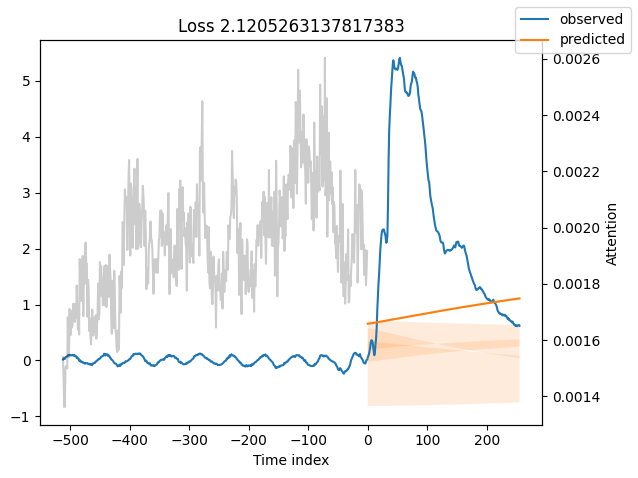

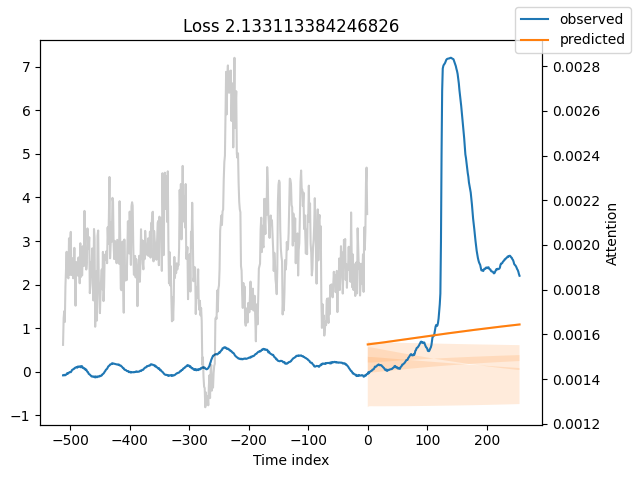

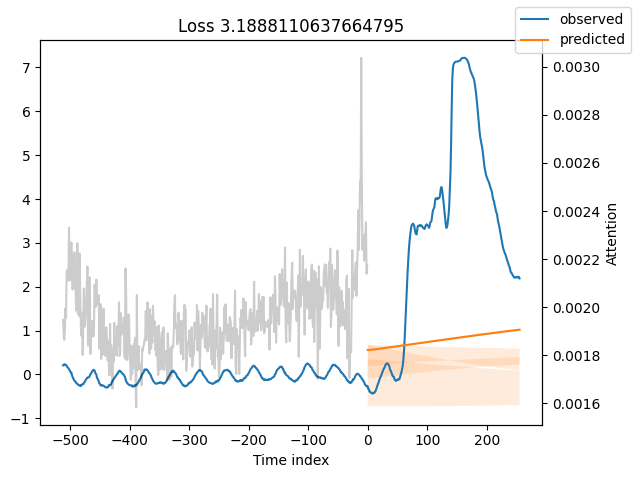

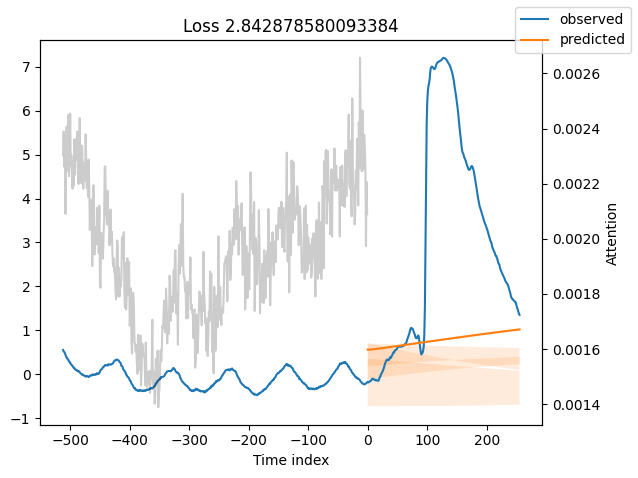

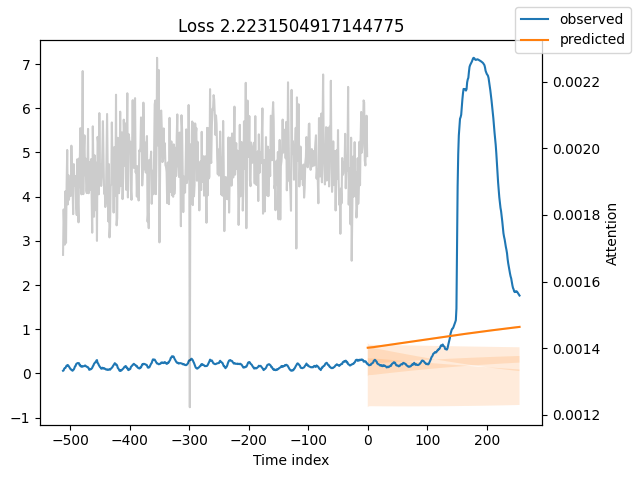

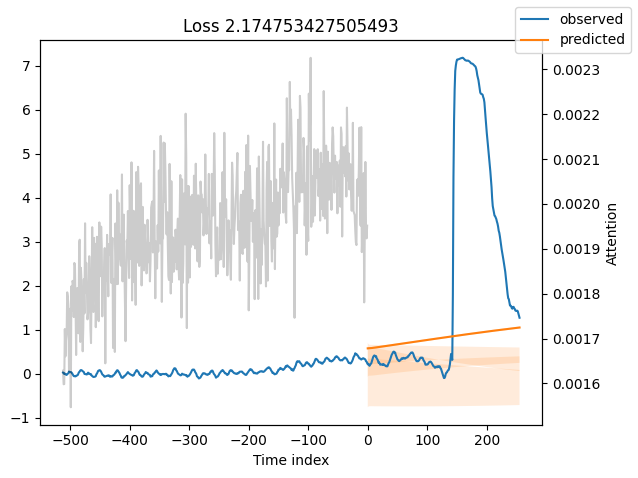

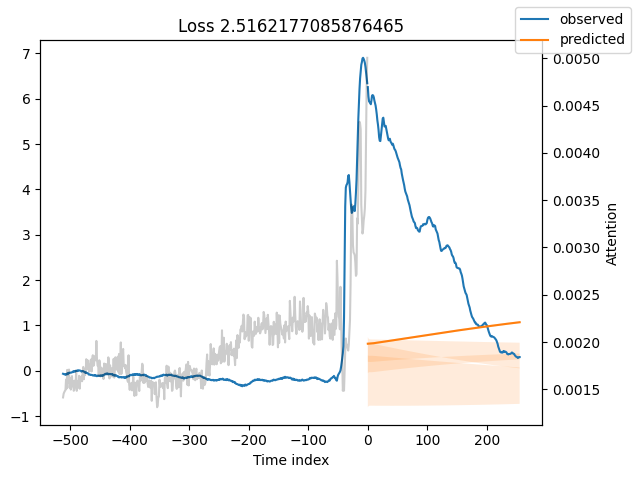

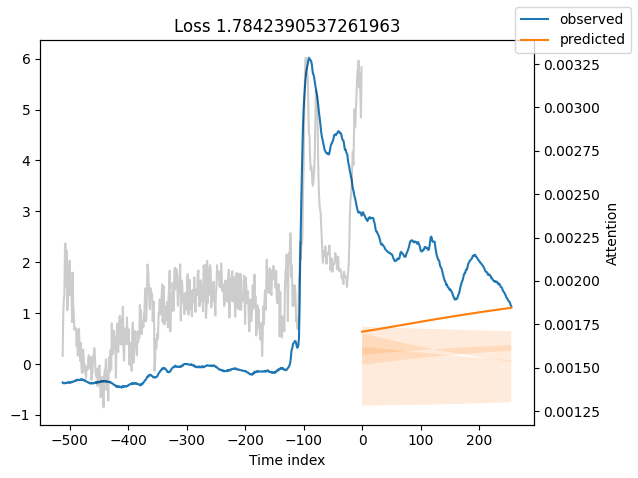

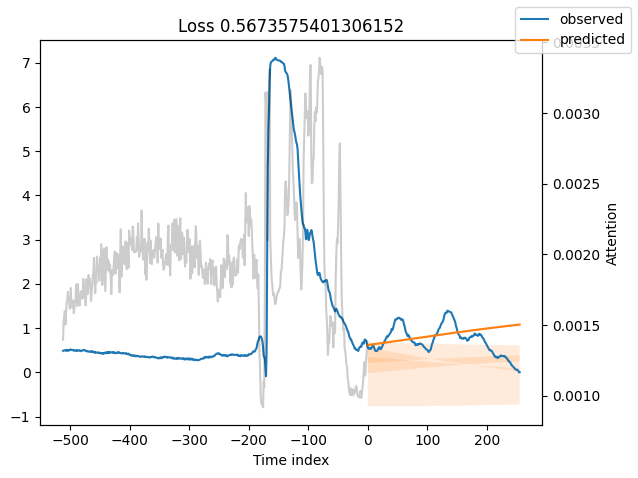

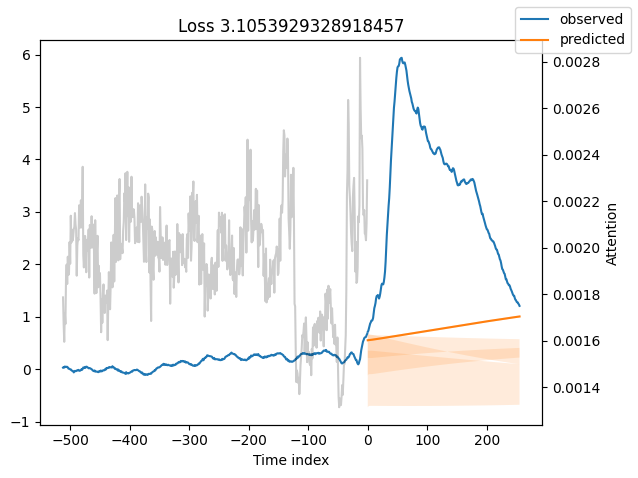

In [20]:
# Plot ten examples of predictions vs actuals. Grey line (not in legend) represents the attention.
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1875 with 1 Axes>,
 'decoder_variables': <Figure size 700x250 with 1 Axes>}

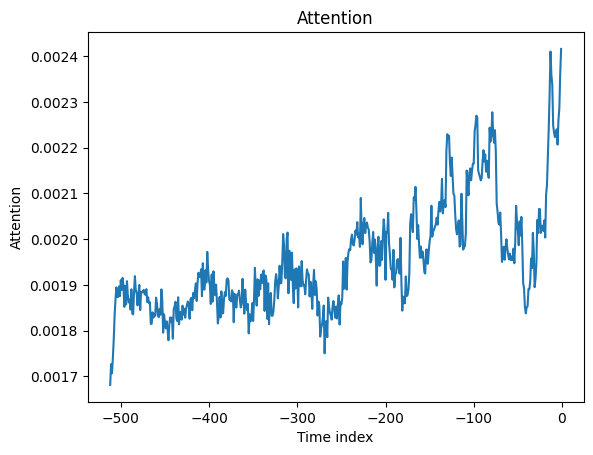

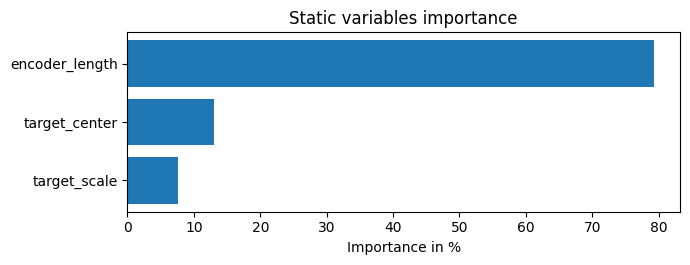

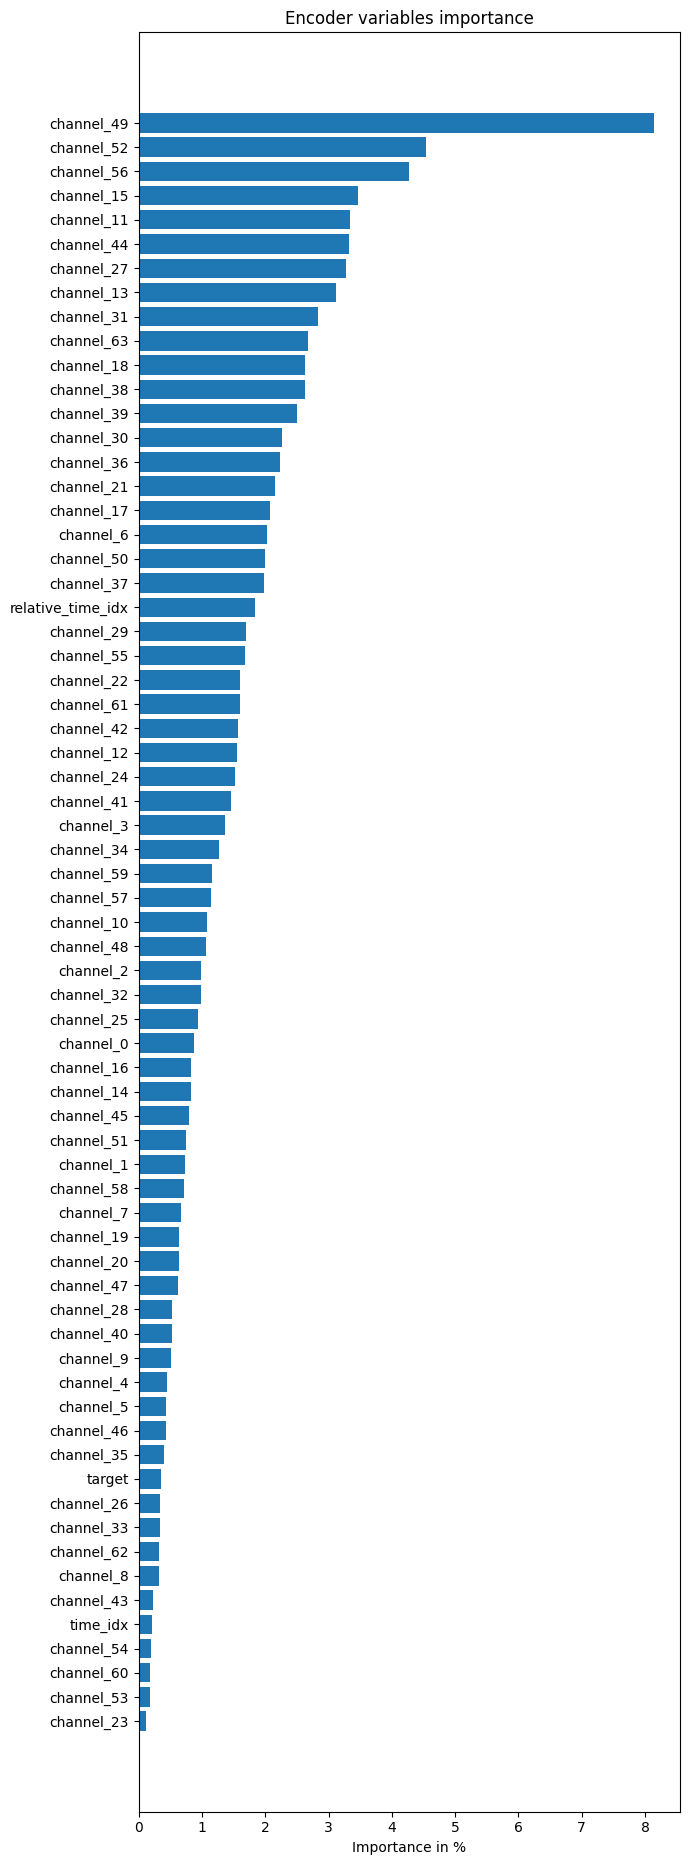

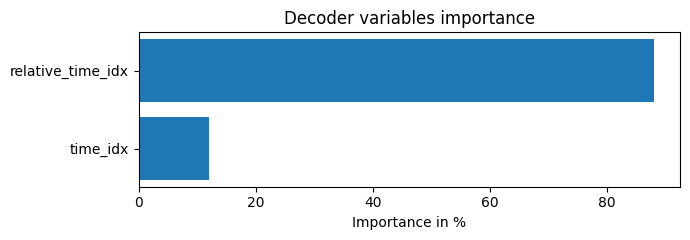

In [21]:
# interpret model
interpretation = best_tft.interpret_output(raw_predictions, reduction='sum')
best_tft.plot_interpretation(interpretation)